In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy import mean

In [3]:
from datetime import datetime as dt
from datetime import timedelta as tdelta
from datetime import date

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect


In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

In [10]:
mea_col = inspector.get_columns('Measurement')
for c in mea_col:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
station_col = inspector.get_columns('Station')
for c in station_col:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


Station

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
latest_date = np.ravel(session.query(Measurement.date).order_by(Measurement.date.desc()).first())
    
import datetime as dt
for item in latest_date:
    Dyear, Dmon, Ddate = item.split('-')
latest_date_new = dt.date(int(Dyear),int(Dmon),int(Ddate))

year_ago = latest_date_new - dt.timedelta(days=365)
print ("Last data point in the database is:", latest_date_new, "\nDate from one year from the last data point is: ", year_ago)

Last data point in the database is: 2017-08-23 
Date from one year from the last data point is:  2016-08-23


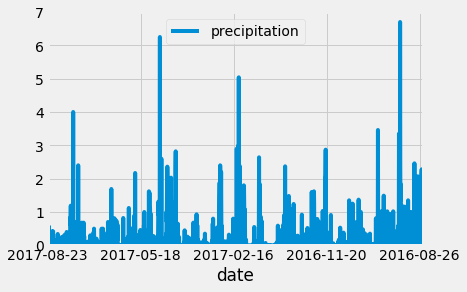

In [17]:
# Perform a query to retrieve the data and precipitation scores
# -- Working-- df1=session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= year_ago).order_by(Measurement.date.desc()).all()
df1 = pd.read_sql_query("select Measurement.date, Measurement.prcp from Measurement where Measurement.date >= '2016-08-23' ORDER BY Measurement.date DESC;", engine)

# Save the query results as a Pandas DataFrame and set the index to the date column
df1.rename(columns = {'date':'date', 'prcp':'precipitation'}, inplace = True) 
df1.set_index('date', inplace=True)

# Sort the dataframe by date
sorted_df1 = df1.sort_values(by=['date'], ascending=False)

# Use Pandas Plotting with Matplotlib to plot the data
sorted_df1.plot(rot=0);
plt.xlabel("date")
plt.ylim(0,7)
plt.legend(["precipitation"])
plt.savefig("./Resources/Figure1.png")
plt.show()

![precipitation](Images/precipitation.png)

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
sorted_df1.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [19]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement.station).group_by(Measurement.station).count()
print("Total Number of Stations ", int(station_count))

Total Number of Stations  9


In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations_measurement = pd.read_sql_query("SELECT station, COUNT(station) from Measurement GROUP BY station HAVING COUNT(station) >1 ;", engine)
active_stations = stations_measurement.sort_values(by=['COUNT(station)'], ascending=False)
active_stations

,station,COUNT(station)
6,USC00519281,2772
1,USC00513117,2696
7,USC00519397,2685
8,USC00519523,2572
3,USC00516128,2484
2,USC00514830,1937
0,USC00511918,1932
4,USC00517948,683
5,USC00518838,342


In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temp_stats_active = pd.read_sql_query("SELECT MIN(tobs), MAX(tobs), AVG(tobs) from Measurement WHERE station='USC00519281'", engine)
temp_stats_active

,MIN(tobs),MAX(tobs),AVG(tobs)
0,54.0,85.0,71.663781


In [22]:
# Choose the station with the highest number of temperature observations.
print(f"The Station with Highest Number of temperature obervations is: ", active_stations['station'].iloc[0], "\nThe No of Observations are: ", active_stations['COUNT(station)'].iloc[0])

The Station with Highest Number of temperature obervations is:  USC00519281 
The No of Observations are:  2772


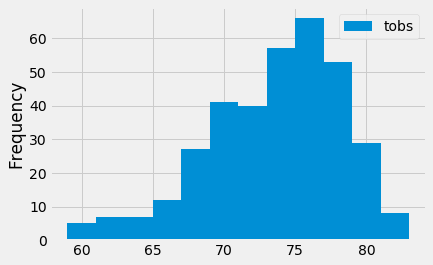

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
stations_tempmeasurement = pd.read_sql_query("SELECT station, COUNT(tobs), tobs from Measurement GROUP BY tobs;", engine)
find_max_df = stations_tempmeasurement.sort_values(by=['COUNT(tobs)'], ascending=False)
df2 = pd.DataFrame(pd.read_sql_query("select tobs from Measurement where station='USC00519281' and date between '2016-08-23' and '2017-08-23';", engine))
ax = df2.plot.hist(bins=12)
plt.savefig("./Resources/Figure2.png")

![precipitation](Images/station-histogram.png)

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
from datetime import datetime
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    start_date = datetime.strptime(start_date, "%Y-%m-%d")
    end_date = datetime.strptime(end_date, "%Y-%m-%d")
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.20930232558139, 74.0)]


In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
startdate = str(year_ago)
enddate = str(latest_date_new)
temp_stats_lastyear = calc_temps(startdate, enddate)
print(temp_stats_lastyear)

[(58.0, 74.48436724565757, 87.0)]


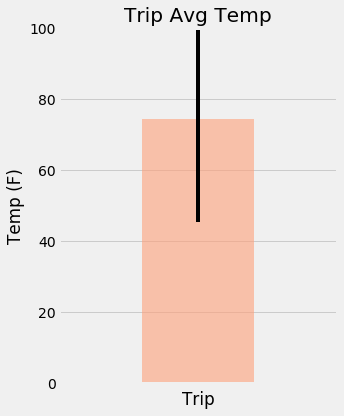

In [28]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
Error = temp_stats_lastyear[0][2]-temp_stats_lastyear[0][0]
AvgTemp = temp_stats_lastyear[0][1]
MinTemp = temp_stats_lastyear[0][0]
MaxTemp = temp_stats_lastyear[0][2]

fig, ax = plt.subplots(figsize=(5,6))
bar_chart = ax.bar(1 , AvgTemp, color= 'lightsalmon', tick_label='',yerr=Error, alpha=0.6)
ax.set_xlabel("Trip")
ax.set_ylabel("Temp (F)")
ax.set_title("Trip Avg Temp")
        
plt.ylim(0, 100)
plt.xlim(0,2)
ax.xaxis.grid()
fig.tight_layout()
plt.savefig("./Resources/Figure3.png")
plt.show()

In [29]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

places = session.query(Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation, func.sum(Measurement.prcp)).\
                            filter(Measurement.station == Station.station).\
                            filter(Measurement.date >= startdate).\
                            filter(Measurement.date <= enddate).\
                            group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
    
dataf = pd.DataFrame(places, columns =['ID', 'Station Name', 'Latitude', 'Longitude', 'Elevation', 'Total Precipitation']) 
dataf

,ID,Station Name,Latitude,Longitude,Elevation,Total Precipitation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,147.81
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,70.03
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,48.51
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,38.01
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,33.24
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,16.09
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,4.59


## Optional Challenge Assignment

In [30]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.06, 77.0)]

In [87]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
trip_start = '2016-08-11'
trip_end = '2016-08-23'

import datetime as dt
from datetime import timedelta
Syear, Smon, Sdate = trip_start.split('-')
trip_start_date = dt.date(int(Syear),int(Smon),int(Sdate))

Eyear, Emon, Edate = trip_end.split('-')
trip_end_date = dt.date(int(Eyear),int(Emon),int(Edate))
TripMonth = Emon
if len(TripMonth) == 1:
    TripMonth= "0" + TripMonth

# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
datesList = [11,12,13,14,15,16,17,18,19,20,21,22,23]
Dates = [f"{TripMonth}-{i}" for i in datesList]

# Loop through the list of %m-%d strings and calculate the normals for each date
for da in Dates:
    Normal = daily_normals(da)
    normals.extend(Normal)
    
normals

[(67.0, 75.74468085106383, 82.0),
 (67.0, 76.46, 83.0),
 (71.0, 76.86, 84.0),
 (71.0, 76.65384615384616, 82.0),
 (69.0, 76.36, 83.0),
 (69.0, 76.14285714285714, 83.0),
 (69.0, 75.94117647058823, 83.0),
 (70.0, 76.80851063829788, 84.0),
 (69.0, 75.8913043478261, 83.0),
 (68.0, 76.20833333333333, 82.0),
 (67.0, 76.25, 83.0),
 (69.0, 76.2127659574468, 84.0),
 (67.0, 76.75510204081633, 87.0)]

In [94]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
import re
tempMin = [x[0] for x in normals]
tempAvg = [x[1] for x in normals]
tempMax = [x[2] for x in normals]
tripDatesYear = [f"{Syear}-{d}" for d in Dates]
tripDatesYear

df_normals = pd.DataFrame({"TempMin":tempMin, "TempAvg":tempAvg, "TempMax":tempMax, "date":tripDatesYear}).set_index("date")
df_normals.head()

,TempMin,TempAvg,TempMax
date,,,
2016-08-11,67.0,75.744681,82.0
2016-08-12,67.0,76.460000,83.0
2016-08-13,71.0,76.860000,84.0
2016-08-14,71.0,76.653846,82.0
2016-08-15,69.0,76.360000,83.0


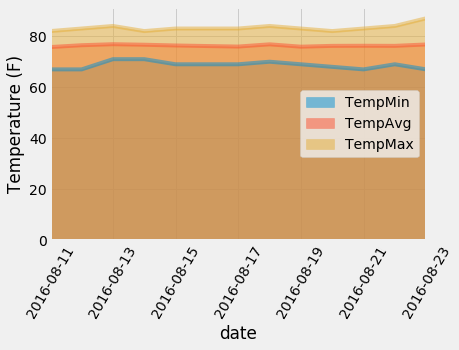

In [100]:
# Plot the daily normals as an area plot with `stacked=False`
df_normals.plot(kind="area", stacked=False)
plt.legend(loc="right")
plt.ylabel("Temperature (F)")
plt.xticks(rotation="60")
plt.savefig("./Resources/daily-normals.png")
plt.show()